# Space Launches in the Private and State Run Sectors
## Jacob Cuomo

### Data import and Cleanse

In [1]:
# Import appropriate libraries
import pandas as pd # loading in data
import numpy as np
import matplotlib.pyplot as plt # creating visualizations
import seaborn as sns # also for creating visualizations
import re # filtering out special characters using regex

# for multiple regression model
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
# Import dataset
space = pd.read_csv('Global_Space_Launches_1.csv')
space.head()

,Company Name,Location,Detail,Status Rocket,Rocket,Status Mission,Country of Launch,Companys Country of Origin,Private or State Run,DateTime,Year,Month,Day,Date,Time
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success,USA,USA,P,2020-08-07 05:12:00+00:00,2020,8,7,07/08/2020,05:12
1,CASIC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,China,China,S,2020-08-06 04:01:00+00:00,2020,8,6,06/08/2020,04:01
2,SpaceX,"Pad A, Boca Chica, Texas, USA",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success,USA,USA,P,2020-08-04 23:57:00+00:00,2020,8,4,04/08/2020,23:57
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success,Kazakhstan,Russia,S,2020-07-30 21:25:00+00:00,2020,7,30,30/07/2020,21:25
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",Atlas V 541 | Perseverance,StatusActive,145.0,Success,USA,USA,P,2020-07-30 11:50:00+00:00,2020,7,30,30/07/2020,11:50


In [3]:
# Quickly look over variables in the space file
space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Company Name                4324 non-null   object
 1   Location                    4324 non-null   object
 2   Detail                      4324 non-null   object
 3   Status Rocket               4324 non-null   object
 4    Rocket                     964 non-null    object
 5   Status Mission              4324 non-null   object
 6   Country of Launch           4324 non-null   object
 7   Companys Country of Origin  4324 non-null   object
 8   Private or State Run        4324 non-null   object
 9   DateTime                    4324 non-null   object
 10  Year                        4324 non-null   int64 
 11  Month                       4324 non-null   int64 
 12  Day                         4324 non-null   int64 
 13  Date                        4324 non-null   obje

In [4]:
# Check if there are any missing values?
print("Are there any missing values?:")
print(space.isnull().values.any())

Are there any missing values?:
True


##### User Visualizations

In [5]:
# Analyze the number of times a company appears, this is the total number of launches for each company
space['Company Name'].value_counts()

RVSN USSR           1777
Arianespace          279
CASIC                256
General Dynamics     251
NASA                 203
VKS RF               201
US Air Force         161
ULA                  140
Boeing               136
Martin Marietta      114
SpaceX               100
MHI                   84
Northrop              83
Lockheed              79
ISRO                  76
Roscosmos             55
ILS                   46
Sea Launch            36
ISAS                  30
Kosmotras             22
US Navy               17
Eurockot              13
ESA                   13
Rocket Lab            13
ISA                   13
Blue Origin           12
IAI                   11
ExPace                10
ASI                    9
AMBA                   8
CNES                   8
Land Launch            7
JAXA                   7
MITT                   7
UT                     5
KCST                   5
Arme de l'Air          4
CECLES                 4
Exos                   4
SRC                    3


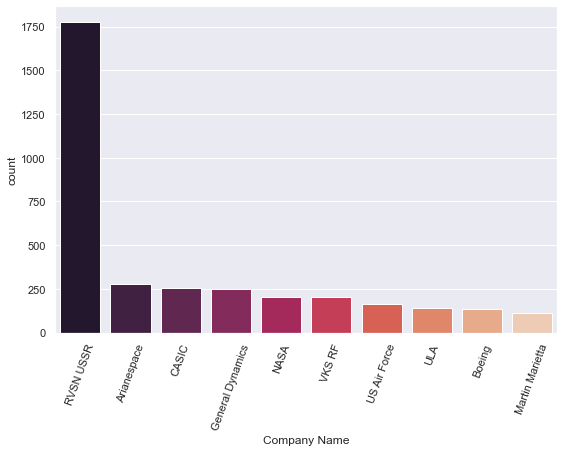

In [7]:
# Create a visualization for the number of launches for each company
sns.set_theme(style="whitegrid") # from Data Science 1500
sns.set(rc={'figure.figsize':(9,6)})
sns.countplot(x="Company Name", data=space, capsize=.1, palette="rocket", 
             order=space["Company Name"].value_counts().iloc[:10].index)

plt.xticks(rotation = 70) # rotate the labels

plt.show()

# CITATION: https://stackoverflow.com/questions/32891211/limit-the-number-of-groups-shown-in-seaborn-countplot

In [9]:
def successful_launches():
    slaunches = dict() # store company and their respective successful launches in a dictionary
    for i in range(len(space)): # loop through each row in the dataset
        company = space["Company Name"][i] # get current company name
        if (space["Status Mission"][i] == "Success"): # if it is successful, keep track of it
            if slaunches.get(company) == None:                   # if slaunch does not exist, create new key in dict
                slaunches[company] = 1
            else:                                             # add 1 to number of slaunches for company
                slaunches[company] = slaunches.get(company) + 1
    
    company_name = list() # list of company names
    company_successful_launches = list() # number of successful launches per company
    
    for key in slaunches: # loop through dictionary 
        company_name.append(key) # add company name to list
        company_successful_launches.append(slaunches[key]) # add company successful launches to list
        
    # remake current dictionary to be able to convert into dataframe easier later on
    slaunches = {
        "Company Name": company_name,
        "Successful Launches": company_successful_launches
    }
    
    return slaunches

successful_launches()

{'Company Name': ['SpaceX',
  'CASIC',
  'Roscosmos',
  'ULA',
  'JAXA',
  'Northrop',
  'IAI',
  'Rocket Lab',
  'VKS RF',
  'MHI',
  'ExPace',
  'IRGC',
  'Arianespace',
  'Blue Origin',
  'ISRO',
  'ILS',
  'i-Space',
  'Eurockot',
  'Land Launch',
  'KCST',
  'Kosmotras',
  'ISA',
  'Khrunichev',
  'Sea Launch',
  'KARI',
  'ESA',
  'NASA',
  'Boeing',
  'ISAS',
  'SRC',
  'MITT',
  'Lockheed',
  'Starsem',
  'RVSN USSR',
  'General Dynamics',
  'Martin Marietta',
  'Yuzhmash',
  'Douglas',
  'ASI',
  'US Air Force',
  'CNES',
  'RAE',
  'UT',
  'CECLES',
  'OKB-586',
  'AMBA',
  "Arme de l'Air",
  'US Navy'],
 'Successful Launches': [94,
  234,
  51,
  139,
  6,
  74,
  9,
  11,
  188,
  80,
  9,
  1,
  269,
  12,
  63,
  45,
  1,
  12,
  6,
  2,
  21,
  4,
  1,
  33,
  1,
  9,
  186,
  131,
  26,
  2,
  6,
  74,
  1,
  1614,
  203,
  100,
  2,
  1,
  9,
  129,
  6,
  1,
  1,
  1,
  2,
  4,
  3,
  2]}

        Company Name  Successful Launches
33         RVSN USSR                 1614
12       Arianespace                  269
1              CASIC                  234
34  General Dynamics                  203
8             VKS RF                  188
26              NASA                  186
3                ULA                  139
27            Boeing                  131
39      US Air Force                  129
35   Martin Marietta                  100
0             SpaceX                   94
9                MHI                   80
5           Northrop                   74
31          Lockheed                   74
14              ISRO                   63
2          Roscosmos                   51
15               ILS                   45
23        Sea Launch                   33
28              ISAS                   26
20         Kosmotras                   21
17          Eurockot                   12
13       Blue Origin                   12
7         Rocket Lab              

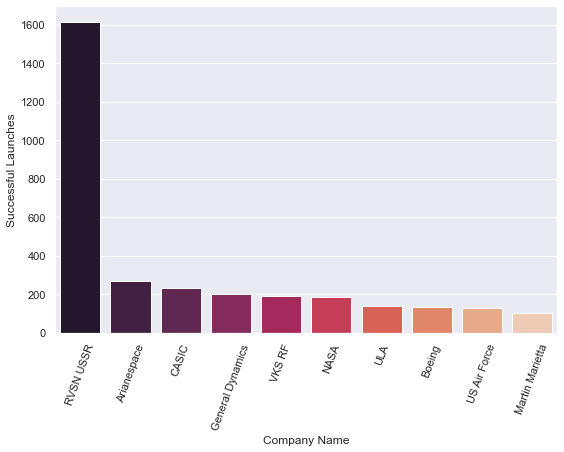

In [10]:
# Create a visualization for the successful launches for each company
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(9,6)})
dictionary = successful_launches()
company_s_launches = pd.DataFrame(dictionary)
company_s_launches.sort_values(by=['Successful Launches'], ascending=False, inplace=True)
print(company_s_launches)

sns.barplot(x="Company Name", y="Successful Launches", data=company_s_launches[:10], palette="rocket")

plt.xticks(rotation = 70) # rotate the labels

plt.show()

### CITATION: https://seaborn.pydata.org/generated/seaborn.countplot.html

In [12]:
# Analyze the number of times a rocket appears in the list, use this value and assign a label to it in a graph later
space[' Rocket'].value_counts()

450.0       136
200.0        75
40.0         55
62.0         41
30.8         38
109.0        37
50.0         34
64.68        34
29.75        33
90.0         32
41.8         31
48.5         26
29.15        25
31.0         22
29.0         22
59.0         22
69.7         17
65.0         16
21.0         16
35.0         16
37.0         15
164.0        15
56.5         15
7.5          14
47.0         13
1,160.0      13
25.0         12
350.0        11
153.0        11
45.0         10
5.3           9
112.5         9
123.0         8
145.0         7
85.0          7
120.0         7
80.0          7
115.0         6
59.5          5
46.0          5
7.0           5
63.23         4
136.6         4
130.0         3
140.0         3
133.0         3
190.0         3
135.0         2
5,000.0       2
39.0          2
55.0          1
20.0          1
15.0          1
20.14         1
12.0          1
28.3          1
Name:  Rocket, dtype: int64

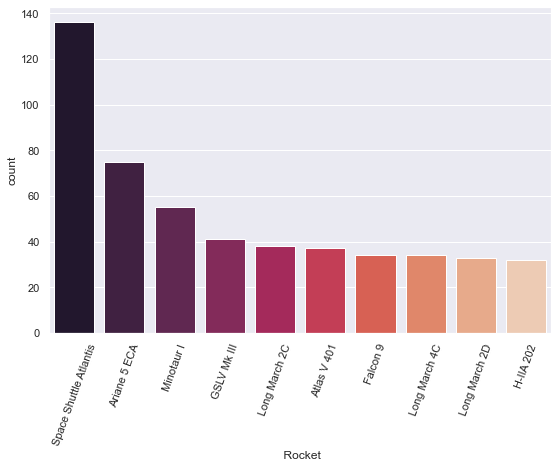

In [19]:
# Create a visualization for the number of rockets for each company
sns.set_theme(style="whitegrid") # from Data Science 1500
sns.set(rc={'figure.figsize':(9,6)})
sns.countplot(x=" Rocket", data=space, capsize=.1, palette="rocket", 
             order=space[" Rocket"].value_counts().iloc[:10].index)

shuttleTicks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
shuttles = ["Space Shuttle Atlantis", "Ariane 5 ECA", "Minotaur I", "GSLV Mk III", "Long March 2C", "Atlas V 401", "Falcon 9", "Long March 4C", "Long March 2D", "H-IIA 202"]
plt.xticks(shuttleTicks, labels=shuttles, rotation = 70)
plt.show()

# CITATION: https://stackoverflow.com/questions/32891211/limit-the-number-of-groups-shown-in-seaborn-countplot